In [1693]:
from __future__ import print_function
# import warnings ; warnings.filterwarnings('ignore') # mute warnings, live dangerously
import matplotlib.pyplot as plt
import matplotlib as mpl ; mpl.use("Agg")
import matplotlib.animation as manimation
import torch
from torch.autograd import Variable
import torch.nn.functional as F

import gym, os, sys, time, argparse
sys.path.append('..')
from visualize_atari import *

In [1700]:
env_name = 'SuperMarioBros-3-1-v0' #, 'SuperMarioBros-1-1-v0', 'SuperMarioBros-6-1-v0'
movement = 'COMPLEX_MOVEMENT' # RIGHT_ONLY, SIMPLE_MOVEMENT, and COMPLEX_MOVEMENT
meta = get_env_meta(env_name)

env = Env_preprocess(env_name, movement = movement) 
test_env = Env_preprocess(env_name, movement = movement)

config_a2cr_eval = {
    'env_name':env_name,
    'env': env,
    'test_env':test_env,
    'movement':movement,
    'add_entropy' :0.001, 
    'add_entropy_times':0, #always 0, non-zero just for Entropy test 
    'Reasoner_CLS': 4}

In [1702]:
A2CRModel_trained = A2CRModel(config_a2cr_eval).to(device)
A2CRModel_Reasoner_trained = A2CRModel_Reasoner(config_a2cr_eval).to(device)
A2CR_path= str(Path(os.path.dirname(os.path.realpath('__file__'))).parents[1])
model_path = A2CR_path + "/"+str(config_a2cr_eval['env'].unwrapped) +"/experiment1_1e6"   #"/experiment_final_2e7" #

A2CRModel_trained.load_state_dict(torch.load(model_path+"/A2C_networks.pt", map_location=torch.device(device)))
A2CRModel_trained.eval()

A2CRModel_Reasoner_trained.load_state_dict(torch.load(model_path+"/Reasoner_networks.pt",map_location=torch.device(device)))
A2CRModel_Reasoner_trained.eval()

evaluate_record = np.load(model_path + "/episode_for_baseline_plot/evaluate_record.npy", allow_pickle=True).item()
history = {'ins':  evaluate_record['states'],
           'logits': evaluate_record['action_ori_prob'],
           'values': evaluate_record['critic_value']}

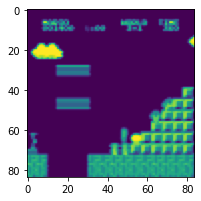

In [1704]:
f = plt.figure(figsize=[3,3*1.3])
frame_ix=268-1 #261
plt.imshow(history['ins'][frame_ix][0,:,:].transpose())
f

## jacobian map

In [1705]:
def jacobian(model, layer, top_dh, X):
    global top_h_ ; top_h_ = None
    def hook_top_h(m, i, o): global top_h_ ; top_h_ = o.clone()
    hook1 = layer.register_forward_hook(hook_top_h)
    _ = model(X) # do a forward pass so the forward hooks can be called

    # backprop positive signal
    torch.autograd.backward(top_h_, top_dh.clone(), retain_graph=True) # backward hooks are called here
    hook1.remove()
    return X.grad.data.clone().numpy(), X.data.clone().numpy()

# derivative is simply the output policy distribution
top_dh_actor = torch.Tensor(history['logits'][frame_ix]).view(1,-1)
top_dh_critic = torch.Tensor(history['values'][frame_ix]).view(1,-1).fill_(1)

# get input
tens_state = torch.Tensor(history['ins'][frame_ix])
state = Variable(tens_state.unsqueeze(0), requires_grad=True)
X = state
actor_jacobian, _ = jacobian(A2CRModel_trained, A2CRModel_trained.actor[-1], top_dh_actor, X)

state.grad.mul_(0) 
X = state
critic_jacobian, _ = jacobian(A2CRModel_trained, A2CRModel_trained.critic[-1], top_dh_critic, X)

## Get perturbation saliency map

In [1706]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from scipy.ndimage.filters import gaussian_filter
from scipy.misc import imresize # preserves single-pixel info _unlike_ img = img[::2,::2]

occlude = lambda I, mask: I*(1-mask) + gaussian_filter(I, sigma=3)*mask # choose an area to blur
searchlight = lambda I, mask: I*mask + gaussian_filter(I, sigma=3)*(1-mask) # choose an area NOT to blur

def get_mask(center, size, r):
    y,x = np.ogrid[-center[0]:size[0]-center[0], -center[1]:size[1]-center[1]]
    keep = x*x + y*y <= 1
    mask = np.zeros(size) ; mask[keep] = 1 # select a circle of pixels
    mask = gaussian_filter(mask, sigma=r) # blur the circle of pixels. this is a 2D Gaussian for r=r^2=1
    return mask/mask.max()

def run_through_model(model, history, ix, interp_func=None, mask=None, blur_memory=None, mode='actor'):
    if mask is None:
        im = history['ins'][ix]
    else:
        assert(interp_func is not None, "interp func cannot be none")
        im = interp_func(history['ins'][ix].squeeze(), mask).reshape(3,84,84) # perturb input I -> I'
    tens_state = torch.Tensor(im)
    state = Variable(tens_state.unsqueeze(0), volatile=True)
    return model(state)[0] if mode == 'critic' else model(state)[1]

def score_frame(model, history, ix, r, d, interp_func, mode='actor'):
    # r: radius of blur
    # d: density of scores (if d==1, then get a score for every pixel...
    #    if d==2 then every other, which is 25% of total pixels for a 2D image)
    assert mode in ['actor', 'critic'], 'mode must be either "actor" or "critic"'
    L = run_through_model(model, history, ix, interp_func, mask=None, mode=mode)
    scores = np.zeros((int(84/d)+1,int(84/d)+1)) # saliency scores S(t,i,j)
    for i in range(0,84,d):
        for j in range(0,84,d):
            mask = get_mask(center=[i,j], size=[84,84], r=r)
            l = run_through_model(model, history, ix, interp_func, mask=mask, mode=mode)
            scores[int(i/d),int(j/d)] = (L-l).pow(2).sum().mul_(.5).data
    pmax = scores.max()
    scores = imresize(scores, size=[84,84], interp='bilinear').astype(np.float32)
    return pmax * scores / scores.max()

radius = 5
density = 5
actor_saliency = score_frame(A2CRModel_trained, history, frame_ix, radius, density, interp_func=occlude, mode='actor')
critic_saliency = score_frame(A2CRModel_trained, history, frame_ix, radius, density, interp_func=occlude, mode='critic')

## upsample

In [1708]:
def saliency_on_atari_frame(saliency, atari, fudge_factor, channel=0, sigma=0):
    # sometimes saliency maps are a bit clearer if you blur them
    # slightly...sigma adjusts the radius of that blur
    if len(saliency.shape) == 3:   #3-D image
        saliency = saliency[channel,:,:]
    else: 
        saliency = saliency  #2-D image

    S = saliency
    S = S if sigma == 0 else gaussian_filter(S, sigma=sigma)
    I = atari
    I[channel,:,:] += S * fudge_factor
    I = I.clip(0.01, 1)
    return I

In [1714]:
# upsample jacobian saliencies
frame = history['ins'][frame_ix].squeeze().copy()
frame = saliency_on_atari_frame((actor_jacobian**2).squeeze(), frame, fudge_factor=1, channel=0, sigma=0)
jacobian_map = saliency_on_atari_frame((critic_jacobian**2).squeeze(), frame, fudge_factor=1, channel=0, sigma=0)

# upsample perturbation saliencies
frame = history['ins'][frame_ix].squeeze().copy()
frame = saliency_on_atari_frame(actor_saliency, frame, fudge_factor=1, channel=0)
perturbation_map = saliency_on_atari_frame(critic_saliency, frame, fudge_factor=0.01, channel=0)

In [1716]:
# Jacobian
f = plt.figure()
plt.imshow(jacobian_map.transpose(2,1,0)[:,:,0])
plt.axis('off')
plt.show()
f
# f.savefig(f'{A2CR_path}/baselines/Jacobian_env3_268.png', bbox_inches='tight')


In [1717]:
f = plt.figure()
plt.imshow(perturbation_map.transpose(2,1,0)[:,:,0])
plt.axis('off')
plt.show()
f
# f.savefig(f'{A2CR_path}/baselines/perturb_env3_268.png', bbox_inches='tight')

In [1712]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def showImagesHorizontally(list_of_files):
    fig = figure()
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(list_of_files[i])
        imshow(image,cmap='Greys_r')
        axis('off')

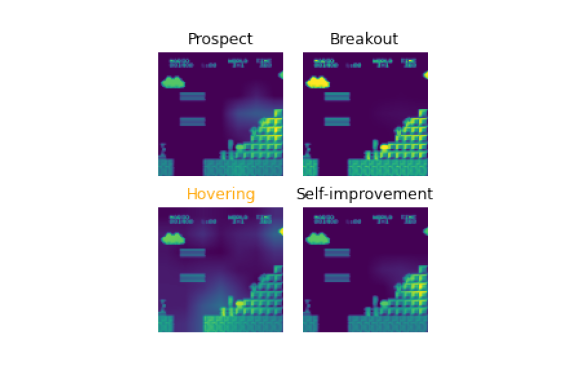

In [1713]:
# frame_ids = [29,30,31,32,33,34]
frame_ids = [frame_ix+1] 
list_of_files = [f'{model_path}/episode_for_baseline_plot/GradCAM_SMap{id}.png' for id in frame_ids]
showImagesHorizontally(list_of_files)

fig = figure(figsize=(10, 10))
number_of_files = len(list_of_files)
for i in range(number_of_files):
    a=fig.add_subplot(1,number_of_files,i+1)
    image = imread(list_of_files[i])
    imshow(image,cmap='Greys_r')
    axis('off')
fig